In [50]:
!pip install ta stable-baselines3==2.1.0 sb3_contrib yfinance
import matplotlib.pyplot as plt
import gymnasium as gym
import gymnasium
from gymnasium import spaces
import pandas as pd
import datetime
import os
import numpy as np
import ta  # Technical Analysis library
from stable_baselines3 import PPO
from sb3_contrib.trpo import TRPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import torch
import yfinance as yf

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## **Functions**
Here are save data and load data + preprocessing function

In [51]:
def save_market_data(df, file_name='market_data.csv'):
    df.to_csv(file_name)

def load_market_data(file_name='market_data.csv'):
    return pd.read_csv(file_name, sep='\t', parse_dates=True)

def preprocess(df: pd.DataFrame):
    # Preprocess
    df["Date"] = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M")  # Specify the exact format
    df.set_index("Date", inplace=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume', 'Spread']

    # Create your features
    df["feature_close"] = df["close"].pct_change()
    df["feature_open"] = df["open"] / df["close"]
    df["feature_high"] = df["high"] / df["close"]
    df["feature_low"] = df["low"] / df["close"]
    df["feature_volume"] = df["volume"] / df["volume"].rolling(7 * 24).max()

    # Add Technical Indicators
    df['SMA_20'] = ta.trend.sma_indicator(df['close'], window=20)
    df['EMA_20'] = ta.trend.ema_indicator(df['close'], window=20)
    df['RSI_14'] = ta.momentum.rsi(df['close'], window=14)
    df['MACD'] = ta.trend.macd_diff(df['close'])
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.volatility.BollingerBands(df['close'],
                                                                                   window=20).bollinger_hband(), \
        ta.volatility.BollingerBands(df['close'], window=20).bollinger_mavg(), \
        ta.volatility.BollingerBands(df['close'], window=20).bollinger_lband()

    # # Add last 50 close positions
    # for i in range(1, 51):
    #     df[f"close_lag_{i}"] = df["close"].shift(i)

    # Add Date, Time, and Day of Week features
    df["date"] = df.index.date
    df["day_of_year"] = df.index.strftime('%j').astype(int)
    df["day_of_week"] = df.index.dayofweek
    df.drop(columns=["date"], inplace=True)
    # Convert 'date' to Unix timestamp (seconds since epoch)
    # df["date"] = pd.to_datetime(df["date"]).astype('int64') / 10 ** 9

    # Convert 'time' to seconds since start of the day
    # df["time"] = df["time"].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

    df.dropna(inplace=True)

    return df

# **StockFetcher**

In [52]:
class StockDataFetcher:
    def __init__(self, symbol, interval, start_date, end_date):
        self.symbol = symbol
        self.interval = interval
        self.start_date = start_date
        self.end_date = end_date
        self.df = None

    def fetch_data(self):
        # Fetch the data using yfinance
        self.df = yf.download(self.symbol, interval=self.interval, start=self.start_date, end=self.end_date)
        # self.df.index = self.df.date.strftime('%Y-%m-%d %H:%M:%S')
        self.df.columns = [x.lower() for x in self.df.columns]
        if self.df.empty:
            raise ValueError("No data was fetched for the given symbol and date range.")

        return self.df

    def add_features(self):
        # Check if data is fetched
        if self.df is None:
            raise ValueError("No data available. Please fetch data first.")

        # Add features
        self.df["feature_close"] = self.df["Close"].pct_change()
        self.df["feature_open"] = self.df["Open"] / self.df["Close"]
        self.df["feature_high"] = self.df["High"] / self.df["Close"]
        self.df["feature_low"] = self.df["Low"] / self.df["Close"]
        self.df["feature_volume"] = self.df["Volume"] / self.df["Volume"].rolling(7 * 24).max()

        return self.df

    def plot_data(self, features=None):
        # Check if data is fetched
        if self.df is None:
            raise ValueError("No data available. Please fetch data first.")

        plt.figure(figsize=(14, 7))

        if features is None:
            # Default to plotting 'Close' price if no features are provided
            plt.plot(self.df.index, self.df['Close'], label='Close Price')
        else:
            # Plot selected features
            for feature in features:
                if feature in self.df.columns:
                    plt.plot(self.df.index, self.df[feature], label=feature)
                else:
                    raise ValueError(f"{feature} is not a valid column in the DataFrame.")

        plt.title(f"{self.symbol} Stock Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.show()


# **Portfolio**

In [53]:
class Portfolio:
    def __init__(self, initial_value=10000):
        self.initial_value = initial_value
        self.assets = {'Cash': self.initial_value}  # Initial cash balance #### Add initial portfolio value to the code
        self.history = []

    def update_assets(self, amount, leverage, profit_loss, stop_loss, timeout, current_step, start_index, trade_type):
        # Calculate trade result based on profit/loss
        trade_result = profit_loss
        # Update portfolio assets based on trade result
        self.assets['Cash'] += trade_result
        # Record trade in history
        self.history.append({
            'trade_type': trade_type,
            'amount': amount,
            'leverage': leverage,
            'profit_loss': profit_loss,
            'stop_loss': stop_loss,
            'timeout': timeout,
            'start_step': start_index,
            'end_step': current_step,
            'result': trade_result,
            'portfolio_value': self.assets['Cash']
        })
        if self.history.__len__() > 150:
            self.history = self.history[-100:]



    def get_portfolio_value(self):
        return self.assets['Cash']

    def get_history(self):
        return pd.DataFrame(self.history)

    def _trade(self, asset_name, amount_fiat, leverage, profit_loss, price_asset, profit_stop, stop_loss, timeout,
               current_step,
               start_index, trade_type):
        """
        Execute a trade and update the portfolio's assets (as a dictionary) and history.

        Parameters:
        - asset_name: The name of the asset being traded (e.g., 'BTC').
        - amount_fiat: The amount in fiat currency to trade.
        - leverage: The leverage applied to the trade.
        - profit_loss: The profit or loss resulting from the trade.
        - price_asset: The current price of the asset.
        - profit_stop: The profit target at which to exit the trade.
        - stop_loss: The loss limit at which to exit the trade.
        - timeout: The maximum duration for which the trade can remain open.
        - current_step: The current step in the trading process.
        - start_index: The index at which the trade started.
        - trade_type: The type of trade (e.g., 'Buy', 'Sell', 'Short', 'Cover').

        Updates:
        - self.assets: Updates the portfolio's assets based on the trade.
        - self.history: Logs the details of the trade in the portfolio's history.
        """

        # Ensure the asset type exists in the assets dictionary
        if asset_name not in self.assets:
            self.assets[asset_name] = 0

        if trade_type == 'Long':  # Opening a long position
            value_change = (amount_fiat * leverage) / price_asset
            self.assets[asset_name] += value_change
            self.assets['Cash'] -= amount_fiat

        elif trade_type == 'Sell':  # Closing a long position
            value_change = price_asset * self.assets[asset_name]
            self.assets[asset_name] = 0
            self.assets['Cash'] += value_change / leverage

        elif trade_type == 'Short':  # Opening a short position
            value_change = (amount_fiat * leverage) / price_asset
            self.assets[asset_name] -= value_change  # Record the shorted amount
            self.assets['Cash'] += amount_fiat

        elif trade_type == 'Cover':  # Closing a short position
            value_change = price_asset * abs(self.assets[asset_name])
            self.assets[asset_name] = 0  # Clear the short position
            self.assets['Cash'] -= value_change / leverage

        # Record the trade in history
        trade_record = {
            'asset_type': asset_name,
            'amount': amount_fiat,
            'leverage': leverage,
            'profit_loss': profit_loss,
            'price': price_asset,
            'profit_stop': profit_stop,
            'stop_loss': stop_loss,
            'timeout': timeout,
            'current_step': current_step,
            'start_index': start_index,
            'trade_type': trade_type,
            'assets_after_trade': self.assets.copy()  # Use copy to capture the state at the time of the trade
        }
        self.history.append(trade_record)

        return trade_record


# **Trading Environment**

In [91]:
leverage = 0
class TradingEnv(gymnasium.Env):
    def __init__(self, df: pd.DataFrame, reward_function=None, initial_portfolio=1000, asset_name='BTC'):
        super(TradingEnv, self).__init__()

        self.df = df
        self.asset_name = asset_name
        self.where_to_start = 0
        self.current_step = self.where_to_start
        self.max_steps = len(df.index)

        # Define the action space using MultiDiscrete
        self.action_space = spaces.MultiDiscrete([
            3,  # Amount (0 to 2)
            # 10,  # Leverage (1 to 10)
            101,  # Profit stop (0 to 100 percent)
            21,  # Stop loss (0 to 20 percent)
            # 270  # Timeout (1 to 100 timesteps)
        ])

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.shape[1],), dtype=np.float32)

        self.position_opened = False
        self.start_index = None
        self.position_details = {
            'amount': 0,
            'leverage': 0,
            'profit_stop': 0,
            'stop_loss': 0,
            'timeout': 0
        }

        self.reward_function = reward_function if reward_function is not None else self.trading_reward_function

        self.portfolio = Portfolio(initial_portfolio)

    def trading_reward_function(self, risk_free_rate=0.01, drawdown_penalty=0.1, min_reward=-100, max_reward=10):
        """
        A literature-based reward function for trading, mapped to a range of -100 to +10.

        Parameters:
        - risk_free_rate: Annual risk-free rate used for calculating Sharpe ratio.
        - drawdown_penalty: Penalty coefficient for drawdown.
        - min_reward: Minimum reward value after scaling.
        - max_reward: Maximum reward value after scaling.

        Returns:
        - reward: Scaled reward within the range [-100, 10].
        """
        try:
            previous_portfolio_value = self.portfolio.history[-3]['assets_after_trade']['Cash']
        except:
            previous_portfolio_value = self.portfolio.initial_value
        portfolio_value = self.portfolio.get_portfolio_value()

        # 1. Profitability (PnL)
        pnl = portfolio_value - previous_portfolio_value

        # 2. Risk-adjusted return (Sharpe Ratio component)
        excess_return = pnl - (risk_free_rate / 252) * previous_portfolio_value
        std_dev = np.std([portfolio_value, previous_portfolio_value])  # Simplified volatility
        sharpe_ratio = excess_return / (std_dev + 1e-2)  # Avoid division by zero

        # 3. Drawdown penalty
        max_portfolio_value = max(portfolio_value, previous_portfolio_value)
        drawdown = (max_portfolio_value - portfolio_value) / max_portfolio_value
        drawdown_penalty_value = drawdown_penalty * drawdown * portfolio_value

        # Final raw reward calculation
        raw_reward = pnl + sharpe_ratio - drawdown_penalty_value

        # Scaling reward to the range [-100, 10]
        raw_min = -500  # Hypothetical minimum raw reward based on testing
        raw_max = 50  # Hypothetical maximum raw reward based on testing
        scaled_reward = min_reward + (raw_reward - raw_min) * (max_reward - min_reward) / (raw_max - raw_min)
        scaled_reward = np.clip(scaled_reward, min_reward, max_reward)  # Ensure reward stays within bounds

        return scaled_reward

    def reset(self, seed=None, **kwargs):
        if seed is not None:
            np.random.seed(seed)
#         self.current_step = np.random.randint(0, int(self.max_steps))
        if self.where_to_start >= self.max_steps-269:
            self.where_to_start = 0
        self.current_step = self.where_to_start
        self.position_opened = False
        self.start_index = self.current_step
        observation = self.df.iloc[self.current_step].values
        return observation, {}

    def step(self, action):
        # Normalize action values and determine the amount based on the action
        if action[0] == 0:
            amount = 0  # Do nothing
        elif action[0] == 1:
            amount = self.portfolio.get_portfolio_value()  # Long position
        elif action[0] == 2:
            amount = self.portfolio.get_portfolio_value()  # Short position

        # Define profit_stop, stop_loss, and timeout based on action parameters
        profit_stop = action[1] / 100.0 * abs(amount)  # Adjust stop profit for both long and short
        stop_loss = action[2] / 100.0 * abs(amount)  # Adjust stop loss for both long and short
        timeout = 270  # Adjust timeout
        # Extract parameters for position management
        profit_loss = 0
        truncated = False
        reason = 'NoPosition'
        risk_to_reward_ratio = stop_loss / float(profit_stop) if profit_stop > 0 else float('inf')
        # Apply penalty if risk-to-reward ratio is not more than 2
        if risk_to_reward_ratio < 2:
            self.current_step += 1
            if self.current_step >= self.max_steps:
                self.current_step = self.max_steps - 1
                done = True
                truncated = True
            else:
                done = False
                truncated = False
            reward = -100
            observation = self.df.iloc[self.current_step].values
            info = {
                'position_opened': self.position_opened,
                'current_step': self.current_step,
                'stop_reason': reason,
#                 'position_details': self.position_details,
                'portfolio_value': self.portfolio.get_portfolio_value(),
#                 'trade_history': self.portfolio.get_history()
            }
            self.where_to_start = self.current_step
            return observation, reward, done, truncated, info

        # If action is 0, proceed to the next step without taking any position
        if action[0] == 0:
            self.current_step += 1
            if self.current_step >= self.max_steps:
                self.current_step = self.max_steps - 1
                done = True
                truncated = True
            else:
                done = False
                truncated = False

            observation = self.df.iloc[self.current_step].values
            reward = 1
            info = {
                'position_opened': self.position_opened,
                'current_step': self.current_step,
                'stop_reason': reason,
#                 'position_details': self.position_details,
                'portfolio_value': self.portfolio.get_portfolio_value(),
#                 'trade_history': self.portfolio.get_history()
            }
            self.where_to_start = self.current_step
            return observation, reward, done, truncated, info

        # If action is 1 (long) or 2 (short), manage the position
        elif action[0] == 1:
            if not self.position_opened:
                # Open a new position
                self.position_opened = True
                self.position_details = {
                    'amount': amount,
                    'profit_stop': profit_stop,
                    'stop_loss': stop_loss,
                    'timeout': timeout
                }
                self.start_index = self.current_step
                # Perform the trade (long or short)
                self.portfolio._trade(
                    asset_name=self.asset_name,
                    amount_fiat=amount,
                    leverage=1,  # Adjust leverage here if needed
                    profit_loss=profit_loss,
                    price_asset=self.df.iloc[self.current_step]['close'],
                    profit_stop=profit_stop,
                    stop_loss=stop_loss,
                    timeout=timeout,
                    current_step=self.current_step,
                    start_index=self.start_index,
                    trade_type='Long'
                )
            done = False
            position_start_price = self.df.iloc[self.start_index]['close']
            while not done:
                self.current_step += 1
                if self.current_step >= self.max_steps:
                    self.current_step = self.max_steps - 1
                    done = True
                    truncated = True
                else:
                    truncated = False
                # Manage the open position
                current_price = self.df.iloc[self.current_step]['close']
                price_change = (current_price - position_start_price) / position_start_price
                # Calculate profit/loss based on long or short position
                profit_loss = price_change * amount if amount > 0 else -price_change * abs(amount)
                    # Move to the next step if position is not closed yet

                # Check if the position should be closed
                if profit_loss >= profit_stop:
                    reason = 'profit_stop'
                    done = True
                elif profit_loss <= -stop_loss:
                    reason = 'stop_loss'
                    done = True
                elif self.current_step - self.start_index >= timeout:
                    reason = 'timeout'
                    done = True

            # Close the trade and update the portfolio
            if done:
                self._close_trade(
                    amount=self.position_details['amount'],
                    price=self.df.iloc[self.current_step]['close'],
                    leverage=1,  # Adjust leverage here if needed
                    profit_stop=profit_stop,
                    stop_loss=stop_loss,
                    timeout=timeout,
                    profit_loss=profit_loss,
                    trade_type='Sell'
                )
                if reason == 'timeout':
                    reward = self.reward_function()
                else:
                    reward = self.reward_function()
                position = True
                self.position_opened = False  # Reset position status
            else:
                reward = 0

            # Prepare the next observation
            observation = self.df.iloc[self.current_step].values if not done else np.zeros_like(self.df.iloc[0].values)

            # Info dictionary with stop reason
            info = {
                'position_opened': position,
                'stop_reason': reason,
                'current_step': self.current_step,
#                 'position_details': self.position_details,
                'portfolio_value': self.portfolio.get_portfolio_value(),
#                 'trade_history': self.portfolio.get_history(),
            }
            self.where_to_start = self.current_step
            return observation, reward, done, truncated, info

        elif action[0] == 2:  # Short position
            if not self.position_opened:
                # Open a new short position
                self.position_opened = True
                amount = - amount
                self.position_details = {
                    'amount': amount,
                    'profit_stop': profit_stop,
                    'stop_loss': stop_loss,
                    'timeout': timeout
                }
                self.start_index = self.current_step
                # Perform the trade (open short position)
                self.portfolio._trade(
                    asset_name=self.asset_name,
                    amount_fiat=amount,
                    leverage=1,  # Adjust leverage here if needed
                    profit_loss=0,  # Initial profit/loss is 0
                    price_asset=self.df.iloc[self.current_step]['close'],
                    profit_stop=profit_stop,
                    stop_loss=stop_loss,
                    timeout=timeout,
                    current_step=self.current_step,
                    start_index=self.start_index,
                    trade_type='Short'
                )

            done = False
            position_start_price = self.df.iloc[self.start_index]['close']
            while not done:
                self.current_step += 1
                if self.current_step >= self.max_steps:
                    self.current_step = self.max_steps - 1
                    done = True
                    truncated = True
                else:
                    truncated = False
                # Manage the open short position
                current_price = self.df.iloc[self.current_step]['close']
                price_change = (current_price - position_start_price) / position_start_price

                # For a short position, profit/loss is inversely related to price change
                profit_loss = -price_change * abs(amount)

                # Check if the position should be closed
                if profit_loss >= abs(profit_stop):  # Target profit reached (price decreased sufficiently)
                    reason = 'profit_stop'
                    done = True
                elif profit_loss <= -abs(stop_loss):  # Stop loss hit (price increased too much)
                    reason = 'stop_loss'
                    done = True
                elif self.current_step - self.start_index >= timeout:
                    reason = 'timeout'
                    done = True
            # Close the short position and update the portfolio
            if done:
                self._close_trade(
                    amount=self.position_details['amount'],
                    price=self.df.iloc[self.current_step]['close'],
                    leverage=1,  # Adjust leverage here if needed
                    profit_stop=profit_stop,
                    stop_loss=stop_loss,
                    timeout=timeout,
                    profit_loss=profit_loss,
                    trade_type='Cover'
                )
                if reason == 'timeout':
                    reward = self.reward_function()
                else:
                    reward = self.reward_function()
                position = True
                self.position_opened = False  # Reset position status
            else:
                reward = 0

            # Prepare the next observation
            observation = self.df.iloc[self.current_step].values if not done else np.zeros_like(self.df.iloc[0].values)

            # Info dictionary with stop reason
            info = {
                'position_opened': position,
                'current_step': self.current_step,
                'stop_reason': reason,
#                 'position_details': self.position_details,
                'portfolio_value': self.portfolio.get_portfolio_value(),
#                 'trade_history': self.portfolio.get_history(),
            }
            self.where_to_start = self.current_step
            return observation, reward, done, truncated, info
        self.where_to_start = self.current_step
        return np.zeros_like(self.df.iloc[0].values), 0, False, False, {
            'position_opened': self.position_opened,
            'current_step': self.current_step,
#             'position_details': self.position_details,
            'portfolio_value': self.portfolio.get_portfolio_value(),
#             'trade_history': self.portfolio.get_history(),
            'stop_reason': reason
        }

    def render(self, mode='human'):
        pass

    def close(self):
        pass

    def default_reward_function(self):
        # use history to develop a reward function
        current_port_val = self.portfolio.assets['Cash']

        try:
            prev_port_val = self.portfolio.history[-3]['assets_after_trade']['Cash']
        except:
            prev_port_val = self.portfolio.initial_value

        return np.log(current_port_val/ prev_port_val)

    def _close_trade(self, amount, price, leverage, profit_loss, profit_stop, stop_loss, timeout, trade_type):
        """
        This function handles closing the trade, converting the trade back to cash,
        and calculating the resulting profit or loss.
        """
        # final_value = amount + (amount * profit_loss)
        self.portfolio._trade(asset_name=self.asset_name, amount_fiat=amount, leverage=leverage, profit_loss=profit_loss,
                              price_asset=price, profit_stop=profit_stop, stop_loss=stop_loss, timeout=timeout,
                              current_step=self.current_step, start_index=self.start_index, trade_type=trade_type)
        self.position_opened = False
        self.position_details = {
            'amount': 0,
            'leverage': 0,
            'profit_stop': 0,
            'stop_loss': 0,
            'timeout': 0
        }

# Some Materials

In [92]:
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import MlpExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
import torch as th
import gymnasium
from stable_baselines3.common.callbacks import BaseCallback


def linear_schedule(initial_value):
    def func(progress):
        return initial_value * (1 - progress)
    return func

# Define a custom policy
class CustomPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, net_arch=None, activation_fn=th.nn.Tanh, *args, **kwargs):
        super(CustomPolicy, self).__init__(observation_space, action_space, lr_schedule, net_arch, activation_fn, *args, **kwargs)

        # Here you can define a custom MLP extractor or any other network you want to use
        self.mlp_extractor = MlpExtractor(self.features_dim, net_arch=[dict(pi=[64, 64], vf=[64, 64])], activation_fn=activation_fn)

    def forward(self, obs: th.Tensor, deterministic: bool = False):
        # Forward pass through the custom network
        features = self.extract_features(obs)
        latent_pi, latent_vf = self.mlp_extractor(features)
        return self._get_action_dist_from_latent(latent_pi, latent_vf, deterministic)

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Custom logic to execute at every step
        if self.n_calls % 1000 == 0:
            print(f"Step number: {self.n_calls}, Reward: {self.model.env.get_attr('reward')}")
        return True

# Now, use this custom policy when initializing the PPO model


# **Main1**

In [93]:
def main1():
    symbol = "EURUSD"
    interval = "5m"
    start_date = '2023-05-01'
    end_date = '2024-08-30'
    data_file = f'./kaggle/input/eurusd-5m-2023-05-01-2024-08-30/{symbol}_{interval}_{start_date}_{end_date}.csv'
    data_file = "/kaggle/input/eurusd-5m-2023-05-01-2024-08-30/EURUSD_5m_2023-05-01_2024-08-30.csv"
    if os.path.exists(data_file):
        print("Loading market data from file...")
        market_data = load_market_data(data_file)
    else:
        print("Fetching market data...")
        fetcher = StockDataFetcher(symbol=symbol, interval=interval, start_date=start_date, end_date=end_date)
        market_data = fetcher.fetch_data()
        save_market_data(market_data, data_file)
        print("Market data saved to file.")
    # Adding new features and technical indicators
    market_data = preprocess(market_data)
    print(market_data.shape)
    # Create the trading environment
    # Initialize the environment
    env = TradingEnv(market_data.iloc[:91193, :], initial_portfolio=1000, asset_name=symbol)
    env = DummyVecEnv([lambda: env])  # Wrap the environment for stable-baselines3

    # Initialize the TRPO agent

    model = TRPO(
        'MlpPolicy',
        env,
        learning_rate=linear_schedule(1e-3),  # Custom learning rate
        n_steps=1024,  # Number of steps to run for each environment per update
        batch_size=128,  # Minibatch size
        # n_epochs=100,  # Number of epochs to run when optimizing the surrogate loss
        gamma=0.99,  # Discount factor
        gae_lambda=0.95,  # GAE lambda
        # clip_range=0.2,  # Clipping parameter
        verbose=1,
        policy_kwargs=dict(
            net_arch=[8000, 1024, 1024, 1024],  # Example network architecture
            activation_fn=torch.nn.ReLU,  # Activation function
            optimizer_class=torch.optim.Adam  # Optimizer
        ),
    )

    # Train the TRPO agent
    model.learn(total_timesteps=10240)

    # Save the trained model
    model.save('trpo_trading_model')

    test_data = market_data.iloc[91193:, :].copy()
    env = TradingEnv(test_data, initial_portfolio=1000, asset_name=symbol)
    env = DummyVecEnv([lambda: env])  # Wrap the environment for stable-baselines3
    # Load the trained model
    model = TRPO.load('trpo_trading_model', env=env)
    portfolio_value_list = []
    observation = env.reset()
    for i in range(100):
        done = False
        truncated = False
        while not done and not truncated:
            # Predict action using the trained PPO model
            action, _states = model.predict(observation, deterministic=True)
            # Take a step in the environment with the predicted action
            observation, reward, done, info = env.step(action)
        portfolio_value_list.append([
            env.envs[0].portfolio.get_portfolio_value(), info[0]["current_step"]
        ])
    portfolio_values = [val[0] for val in portfolio_value_list]
    steps = [val[1] for val in portfolio_value_list]
    plt.plot(steps, portfolio_values)
#         plt.xticks(steps)
    plt.xlabel("Step")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("100_trades_TRPO_7-10240-timestamps_V1.png", dpi=300)
    with open("100_trades_TRPO_7-10240-timestamps_V1.txt", 'w') as file:
        for row in portfolio_value_list:
            s = " ".join(map(str, row))
            file.write(s+'\n')


# **RUN**

Loading market data from file...
(99833, 20)
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 262  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 1024 |
-----------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 214      |
|    iterations             | 2        |
|    time_elapsed           | 9        |
|    total_timesteps        | 2048     |
| train/                    |          |
|    explained_variance     | 0.000965 |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00632  |
|    learning_rate          | 0.0001   |
|    n_updates              | 1        |
|    policy_objective       | 0.0494   |
|    value_loss             | 2.37e+05 |
----------------------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 

/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

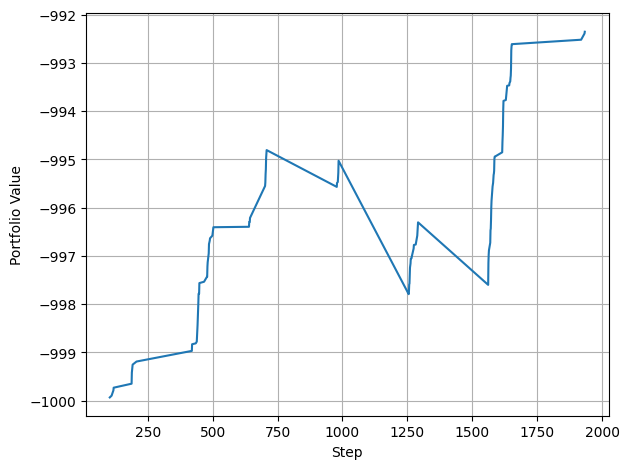

In [94]:

if __name__ == "__main__":
    main1()